# Overview
- crop raw HPA images to desired dimentions
- ensure that at least 5% of the pixels represent cellular stuctures (i.e. non-background pixels)

In [1]:
import os
import numpy as np
import h5py
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

# load utils
from utils_simulation import colour_channel_imgs

In [2]:
# Define parameters
img_dir = 'data/HPA_raw'  # Directory containing raw HPA images
save_dir = 'data/cropped_imgs'  # Directory to save cropped images
window_size = (256, 256)  #  Window size for cropped images
percentage_thersh = 5  # Minimum percentage of non-background pixels

In [3]:
imgs = os.listdir(img_dir) # Get image names 
imgs_id = list(set([x.split('_')[0] for x in imgs])) # Keep only unique image ids i.e. remove colour channel info

## Plotting example image

Each image is composed of four colour channels:
- red: microtubules,
- green: prot. of interest
- blue: nucleus
- yellow: ER

In [4]:
selectd_img = imgs_id[0]
r, g, b, y = colour_channel_imgs(img_dir, selectd_img) # Load colour channels of selected image
image = np.dstack((r, g, b, y)) # Combine colour channels to get multi-channel image

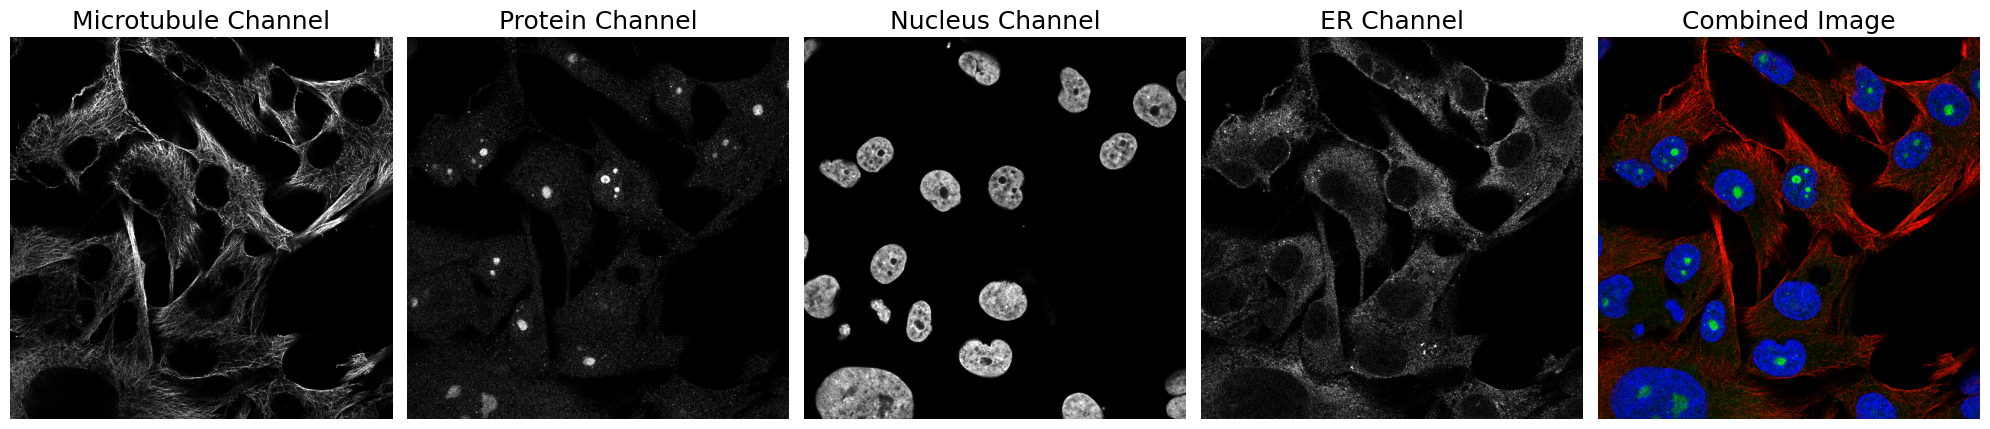

In [5]:

# Plot the individual channels and the combined image
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Display each channel separately
axes[0].imshow(r, cmap='gray')
axes[0].set_title("Microtubule Channel", fontsize = 18)
axes[0].axis('off')

axes[1].imshow(g, cmap='gray')
axes[1].set_title("Protein Channel", fontsize = 18)
axes[1].axis('off')

axes[2].imshow(b, cmap='gray')
axes[2].set_title("Nucleus Channel", fontsize = 18)
axes[2].axis('off')

axes[3].imshow(y, cmap='gray')
axes[3].set_title("ER Channel", fontsize = 18)
axes[3].axis('off')

# Display the combined image
# Normalizing values for display if needed (optional)
combined_image = image / np.max(image, axis=(0, 1)) if np.max(image) > 1 else image
axes[4].imshow(combined_image[:, :, :3])  # Only RGB channels (cannot visualise 4th channel)
axes[4].set_title("Combined Image", fontsize = 18)
axes[4].axis('off')

plt.tight_layout()
plt.show()

# Crop images

In [6]:
def get_cropped_images(image_id, img_dir, window_size, percentage_threshold, save=False, save_dir=None):
    """
    Extract and save cropped images using a sliding window approach.
    
    Parameters:
    -----------
    image_id : Image name for the image being processed
    img_dir : Path to the directory containing the image
    window_size : Dimensions of the sliding window (height, width)
    percentage_threshold : Minimum percentage of non-zero pixels required to keep the cropped image
    save : Whether to save the cropped images to disk (default is False)
    save_dir : Directory where cropped images will be saved if `save` is True
    """
    
    # Initialise a dictionary to store cropped image arrays
    image_dict = {}
    cropped_img_count = -1
    
    # Load each color channel of the image
    r, g, b, y = colour_channel_imgs(img_dir, image_id)
    # Stack color channels to get the multi-channel image
    image = np.dstack((r, g, b, y))
    
    # Iterate through the image using a sliding window
    for y in range(0, image.shape[0], window_size[0]):
        for x in range(0, image.shape[1], window_size[1]):
            # Calculate the size of the current window
            window_height = min(window_size[0], image.shape[0] - y)
            window_width = min(window_size[1], image.shape[1] - x)
            
            # Extract the current window using numpy slicing
            cropped_window = image[y:y+window_height, x:x+window_width]
            
            # Skip windows that are smaller than the desired size
            if cropped_window.shape[:2] == tuple(window_size):
                # Calculate the percentage of non-zero pixels
                non_zero_percentage = round(
                    (np.count_nonzero(np.sum(cropped_window, axis=-1)) / cropped_window.size) * 100)
                # Check if the percentage of non-background pixels exceeds the threshold
                if non_zero_percentage > percentage_threshold:
                    # Increment the cropped image counter
                    cropped_img_count += 1
                    # Store the cropped window in the dictionary
                    image_dict[f"{image_id}_{cropped_img_count}"] = cropped_window
                    
                    # Save the cropped window to disk if `save` is True
                    if save:
                        if save_dir is None:
                            raise ValueError("`save_dir` must be specified if `save` is True.")
                        
                        # Ensure the save directory exists
                        os.makedirs(save_dir, exist_ok=True)
                        # Define the save path for the cropped image
                        save_path = os.path.join(save_dir, f"{image_id}_{cropped_img_count}.h5")
                        # Save the cropped window as an HDF5 file
                        with h5py.File(save_path, 'w') as hf:
                            hf.create_dataset('raw_intensity', data=cropped_window)
    
    return image_dict


In [7]:
def plot_images_from_dict(image_dict):
    """Plot cropped images"""
    
    if not image_dict:
        print("The dictionary is empty. No images to plot.")
        return
    
    # Determine the number of images
    num_images = len(image_dict)
    
    # Calculate the grid size for subplots
    cols = min(5, num_images)  # Limit to 5 images per row
    rows = math.ceil(num_images / cols)
    
    # Create a figure for the images
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.ravel() if num_images > 1 else [axes]  # Handle single image case
    
    # Iterate through the dictionary and plot each image
    for idx, (key, image) in enumerate(image_dict.items()):
        ax = axes[idx]
        ax.imshow(image[:, :, :3])  # Use grayscale for 2D images
        ax.set_title(f"Combined image (RGB):{idx}", fontsize=10)
        ax.axis('off')
    
    # Turn off any remaining unused subplots
    for idx in range(len(image_dict), len(axes)):
        axes[idx].axis('off')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

Processing Images:   0%|          | 0/2 [00:00<?, ?image/s]

Plotting results for 00b1b8b8-bba5-11e8-b2ba-ac1f6b6435d0


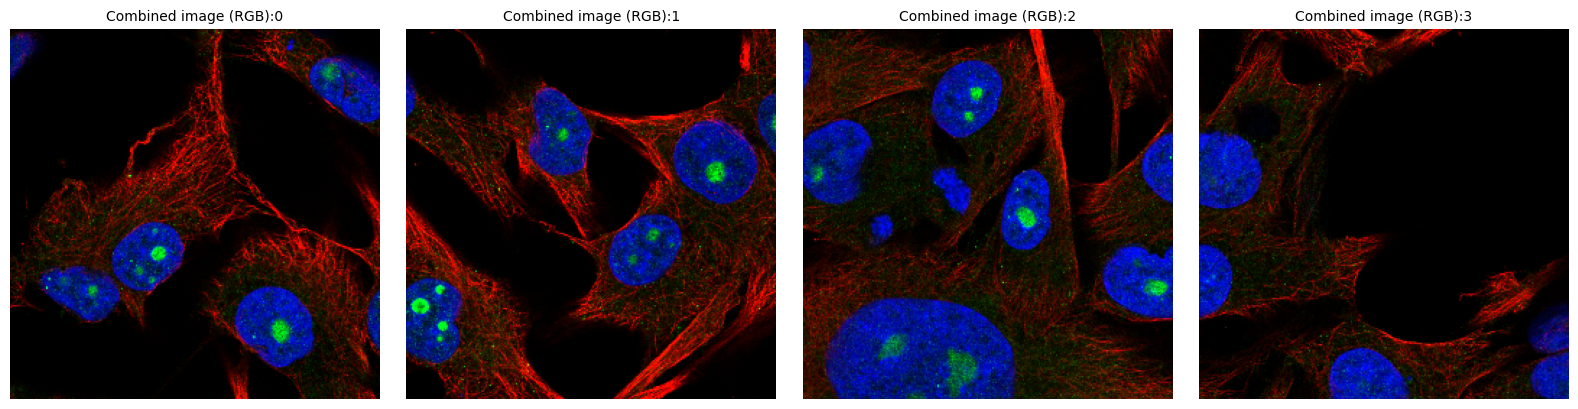

Processing Images:  50%|█████     | 1/2 [00:01<00:01,  1.72s/image]

Plotting results for 00ae0ea6-bb9c-11e8-b2b9-ac1f6b6435d0


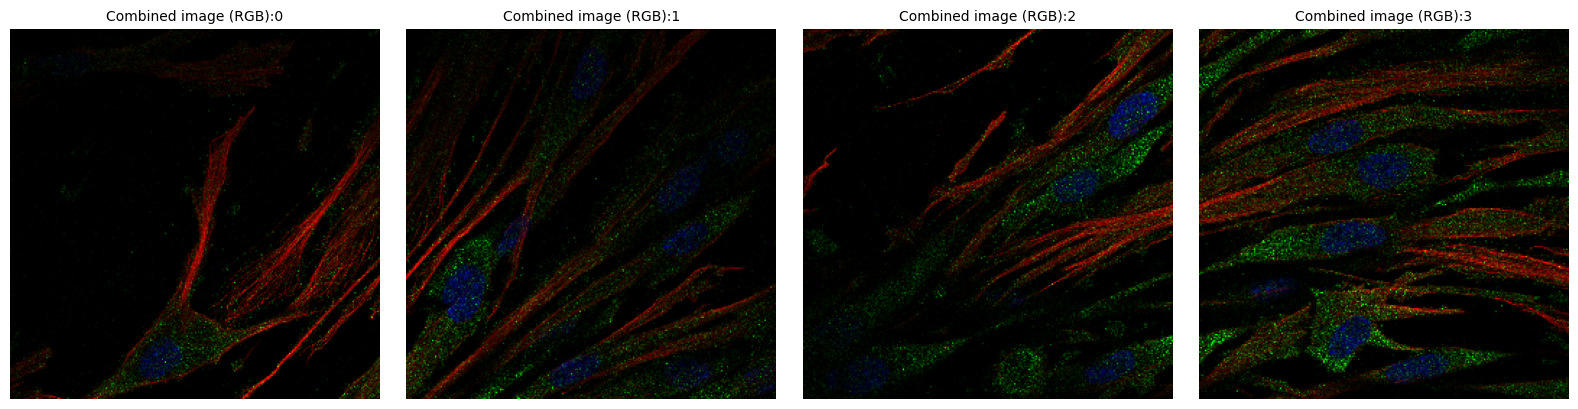

Processing Images: 100%|██████████| 2/2 [00:03<00:00,  1.71s/image]


In [8]:
plot = True
for i in tqdm(imgs_id, desc="Processing Images", unit="image"):
    out = get_cropped_images(image_id=i, img_dir=img_dir, window_size=window_size, 
                                  percentage_threshold=percentage_thersh, save=True, save_dir=save_dir)
    # Visualise cropped images
    if plot == True:
        print(f"Plotting results for {i}")
        plot_images_from_dict(out)